In [ ]:
base_path = "/content/drive/My Drive/Github/mtc-device-activation"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,923 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:13 https://ppa.la

Chosen SNR (dB): 12


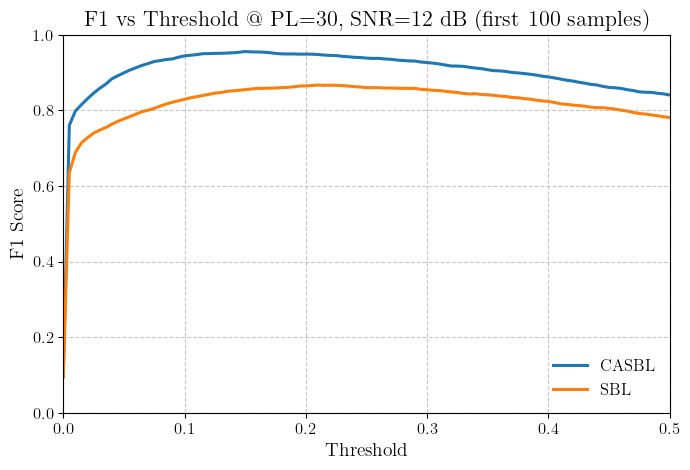

In [ ]:
# === Load general simulation data ===
data = np.load(f"{base_path}/communication_model/data/communication_simulation_general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

# === Load ground truth ===
all_gamma = np.load(f"{base_path}/communication_model/data/communication_simulation_gamma.npz", allow_pickle=True)["all_gamma"]  # (S, N)
all_z     = np.load(f"{base_path}/communication_model/data/communication_simulation_z.npz", allow_pickle=True)["all_z"]        # (S, N, M)

def load_estimates(folder_name, file_prefix, num_sets=5):
    """Loads and concatenates estimation results from multiple .npz files."""
    file_paths = [
        f"{base_path}/estimation/{folder_name}/data/{file_prefix}_set_{i}.npz"
        for i in range(1, num_sets + 1)
    ]
    all_z_est, all_gamma_est = [], []
    for path in file_paths:
        est = np.load(path, allow_pickle=True)
        all_z_est.append(est["z_result_all"])          # expected (S_i, num_snr, N, M)
        all_gamma_est.append(est["gamma_result_all"])  # expected (S_i, num_snr, N)
    return np.concatenate(all_z_est, axis=0), np.concatenate(all_gamma_est, axis=0)

# === Load fixed PL=30, varying SNR ===
folder_fixedPL = "snr_db_all_pilot_length_30"
z_est_casbl_all, gamma_est_casbl_all = load_estimates(folder_fixedPL, "casbl_snr_db_all_pilot_length_30")
z_est_sbl_all,   gamma_est_sbl_all   = load_estimates(folder_fixedPL, "sbl_snr_db_all_pilot_length_30")

# === Use only first 100 samples ===
num_samples_use = min(100, all_gamma.shape[0])
all_gamma_use = all_gamma[:num_samples_use]
all_z_use     = all_z[:num_samples_use]
z_est_casbl_all = z_est_casbl_all[:num_samples_use]
gamma_est_casbl_all = gamma_est_casbl_all[:num_samples_use]
z_est_sbl_all   = z_est_sbl_all[:num_samples_use]
gamma_est_sbl_all = gamma_est_sbl_all[:num_samples_use]

# === Select SNR = 12 dB (3rd entry) ===
snr_idx = 2  # 0-based index
print("Chosen SNR (dB):", snr_db_array[snr_idx])

# Slice SNR axis -> shapes: z_est: (S, N, M), gamma_est: (S, N)
z_est_casbl = z_est_casbl_all[:, snr_idx]
gamma_est_casbl = gamma_est_casbl_all[:, snr_idx]
z_est_sbl = z_est_sbl_all[:, snr_idx]
gamma_est_sbl = gamma_est_sbl_all[:, snr_idx]

# === Threshold sweep (fine-grained) ===
threshold_array = np.linspace(0.00, 0.50, 101)  # 0.00 to 0.50 step 0.005

def f1_vs_threshold(all_gamma_true, gamma_est, thresholds):
    """Compute F1 vs threshold using your original F1 logic."""
    f1_vals = []
    S = all_gamma_true.shape[0]
    for thr in thresholds:
        f1_list = []
        for s in range(S):
            gamma_true = all_gamma_true[s]   # (N,)
            gamma_hat  = gamma_est[s]        # (N,)

            gamma_hat_bool = (gamma_hat > thr)

            TP = np.sum((gamma_hat_bool == 1) & (gamma_true == 1))
            FP = np.sum((gamma_hat_bool == 1) & (gamma_true == 0))
            FN = np.sum((gamma_hat_bool == 0) & (gamma_true == 1))

            precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
            recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

            f1_list.append(f1)
        f1_vals.append(np.mean(f1_list))
    return np.array(f1_vals)

# === Compute F1 curves ===
f1_casbl = f1_vs_threshold(all_gamma_use, gamma_est_casbl, threshold_array)
f1_sbl   = f1_vs_threshold(all_gamma_use, gamma_est_sbl,   threshold_array)

# Set global plot parameters
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
})

# === Fine-tuned plot ===
plt.figure(figsize=(7, 4.8))
plt.plot(threshold_array, f1_casbl, linewidth=2.2, marker=None, label="CASBL")
plt.plot(threshold_array, f1_sbl,   linewidth=2.2, marker=None, label="SBL")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold @ PL=30, SNR=12 dB (first 100 samples)")
plt.xlim(threshold_array.min(), threshold_array.max())
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--")
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()